In [1]:
# Libraries for analysis, preprocessing, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import kruskal, ttest_ind
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest


In [2]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Shape and feature info
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.dtypes.value_counts())
print(train.info())
print("Missing values (train):\n", train.isnull().sum())
print("Activity class distribution (train):\n", train['Activity'].value_counts())


Train shape: (7352, 563)
Test shape: (2947, 563)
float64    561
int64        1
object       1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None
Missing values (train):
 tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64
Activity class distribution (train):
 Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


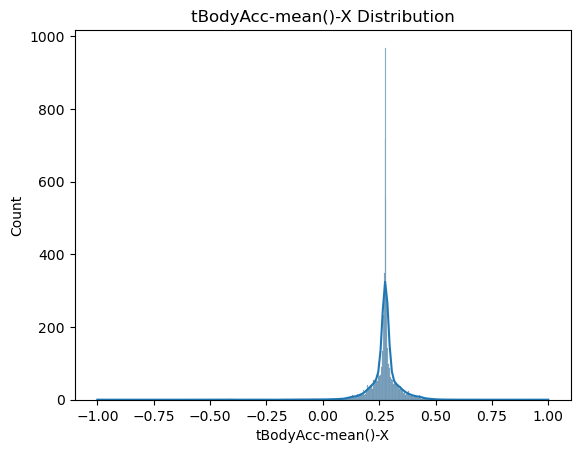

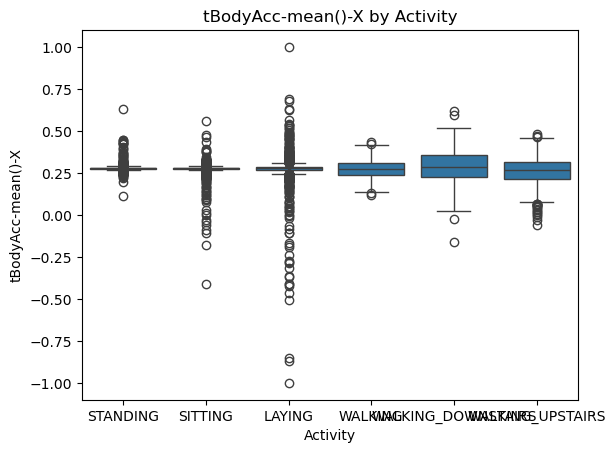

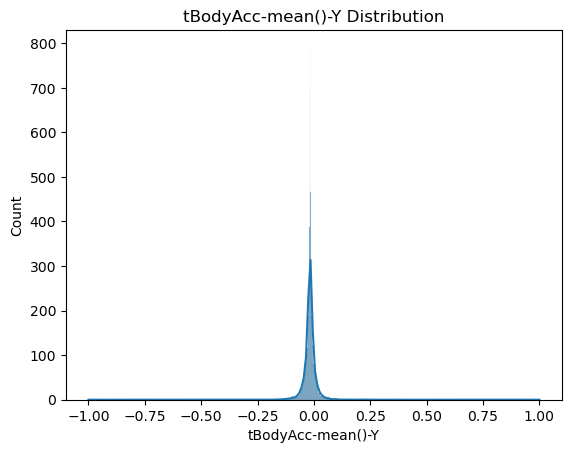

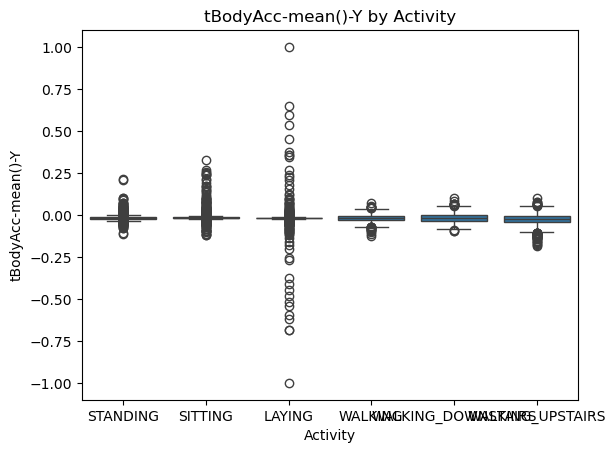

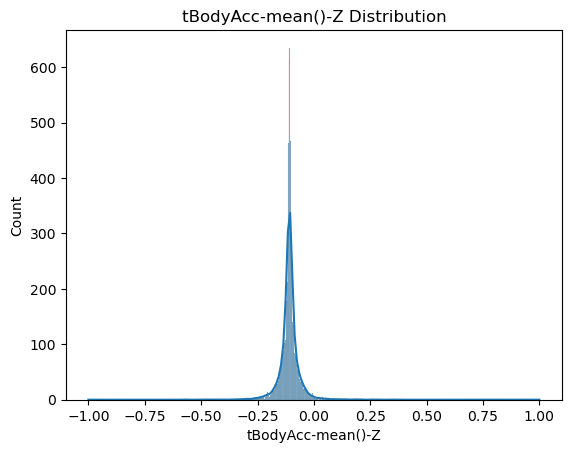

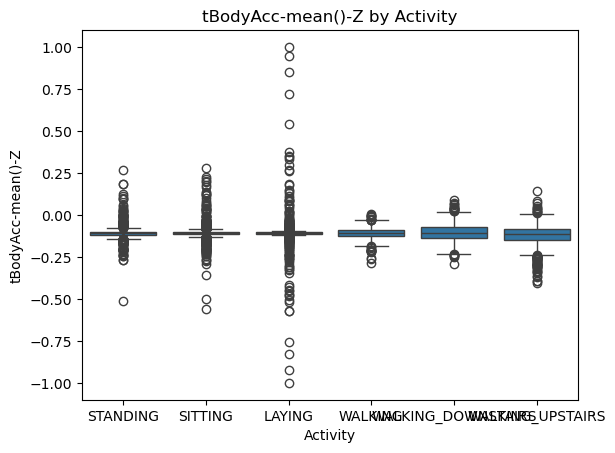

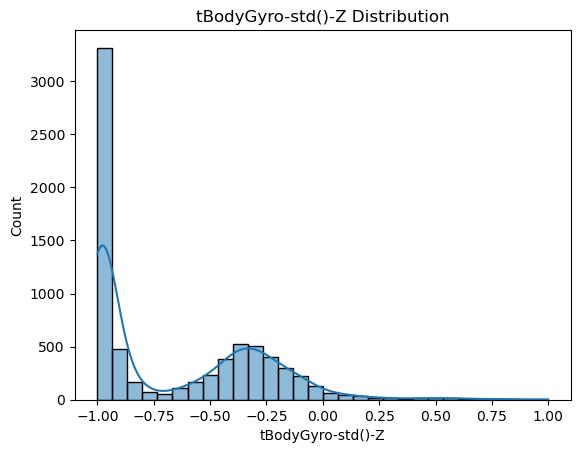

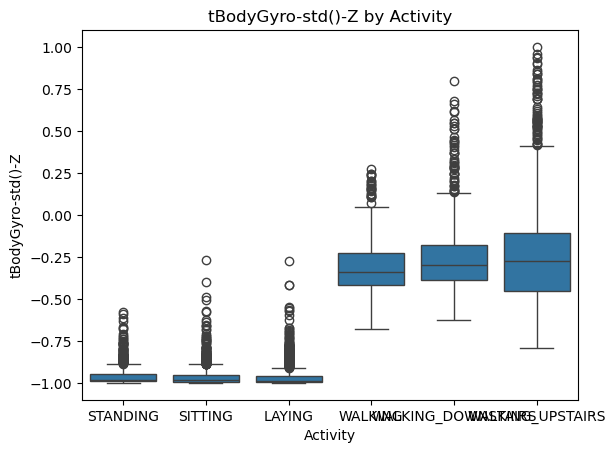

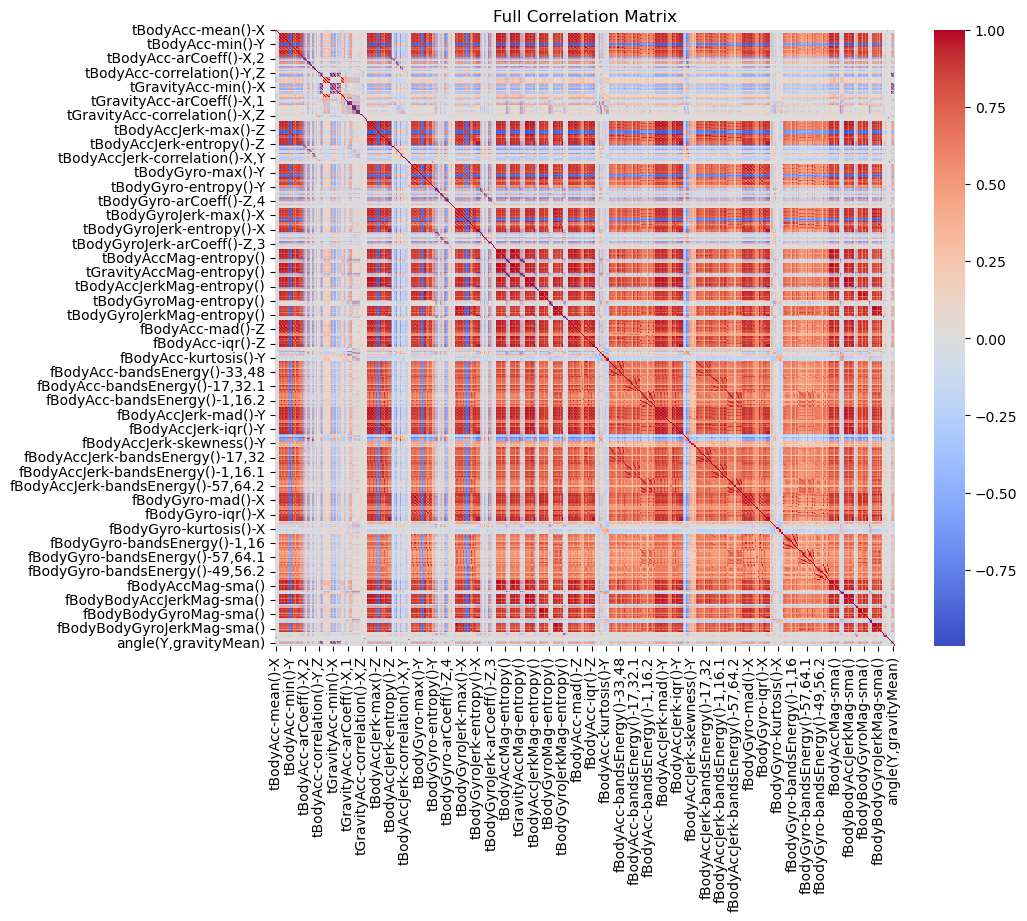

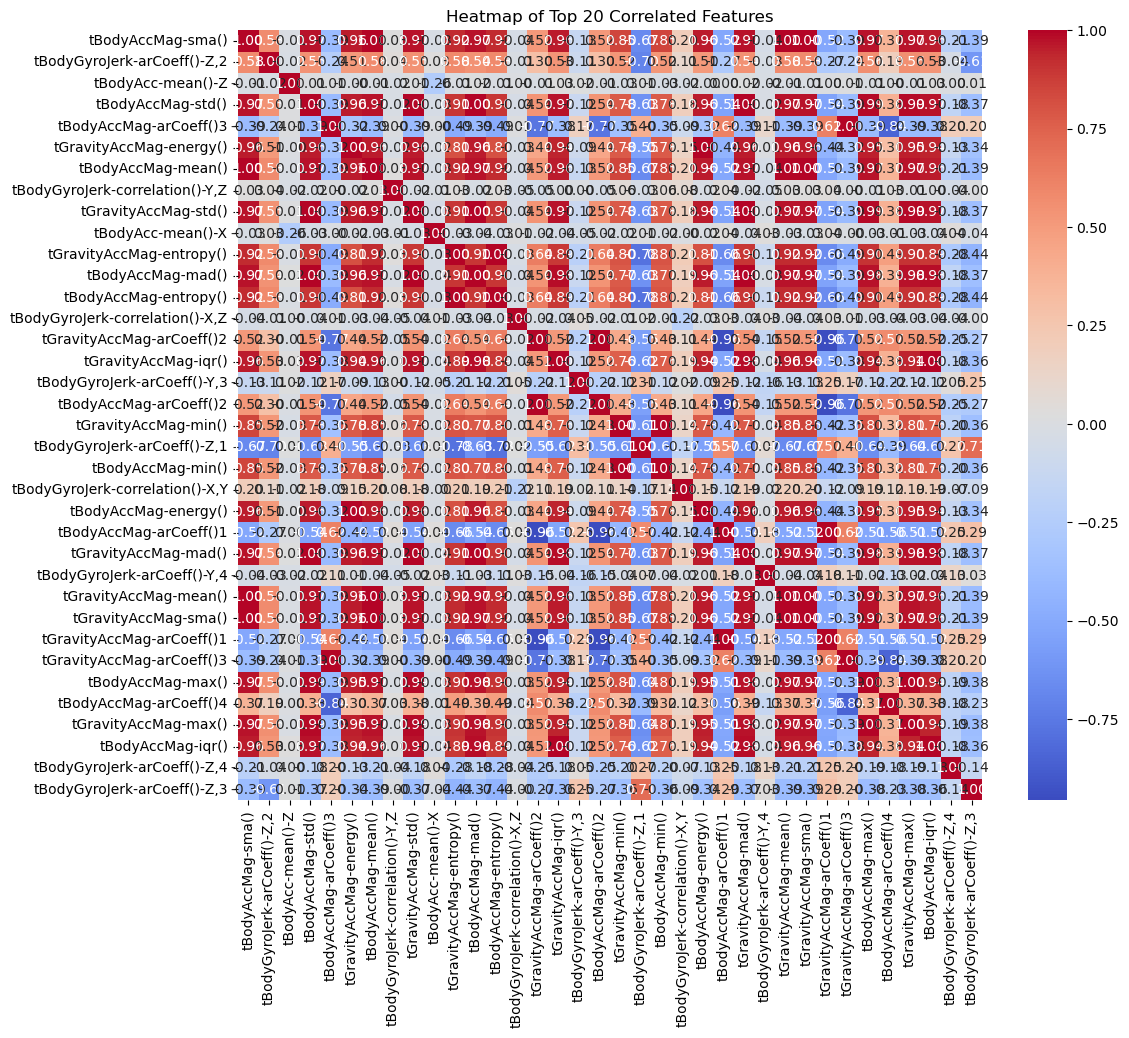

In [3]:
# Representative features for exploration
features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyGyro-std()-Z']

# Distribution plots
for feat in features:
    sns.histplot(train[feat], kde=True)
    plt.title(f'{feat} Distribution')
    plt.show()
    sns.boxplot(x='Activity', y=feat, data=train)
    plt.title(f'{feat} by Activity')
    plt.show()

# Correlation matrix & heatmap
corr_mat = train.drop(columns=['Activity']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, cmap='coolwarm', center=0)
plt.title("Full Correlation Matrix")
plt.show()

# Top correlated features heatmap
top_corr = corr_mat.abs().unstack().sort_values(kind="quicksort", ascending=False)
top_feats = list(set([i[0] for i in top_corr[:40].index] + [i[1] for i in top_corr[:40].index]))
plt.figure(figsize=(12,10))
sns.heatmap(train[top_feats].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap of Top 20 Correlated Features")
plt.show()


Interpretation:
Highly correlated features suggest redundancy (multicollinearity) which can destabilize some models (Logistic Regression). Feature selection or reduction may be necessary.

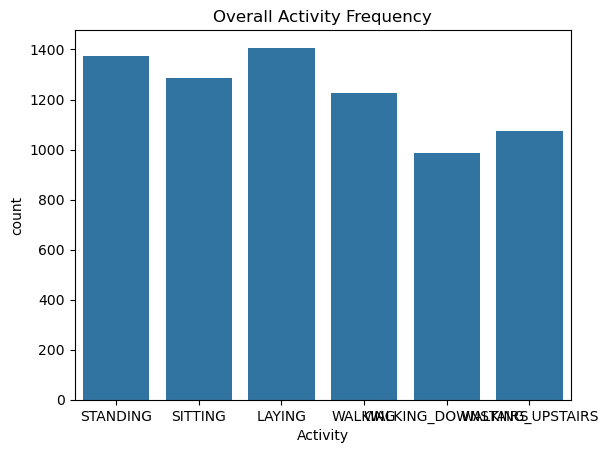

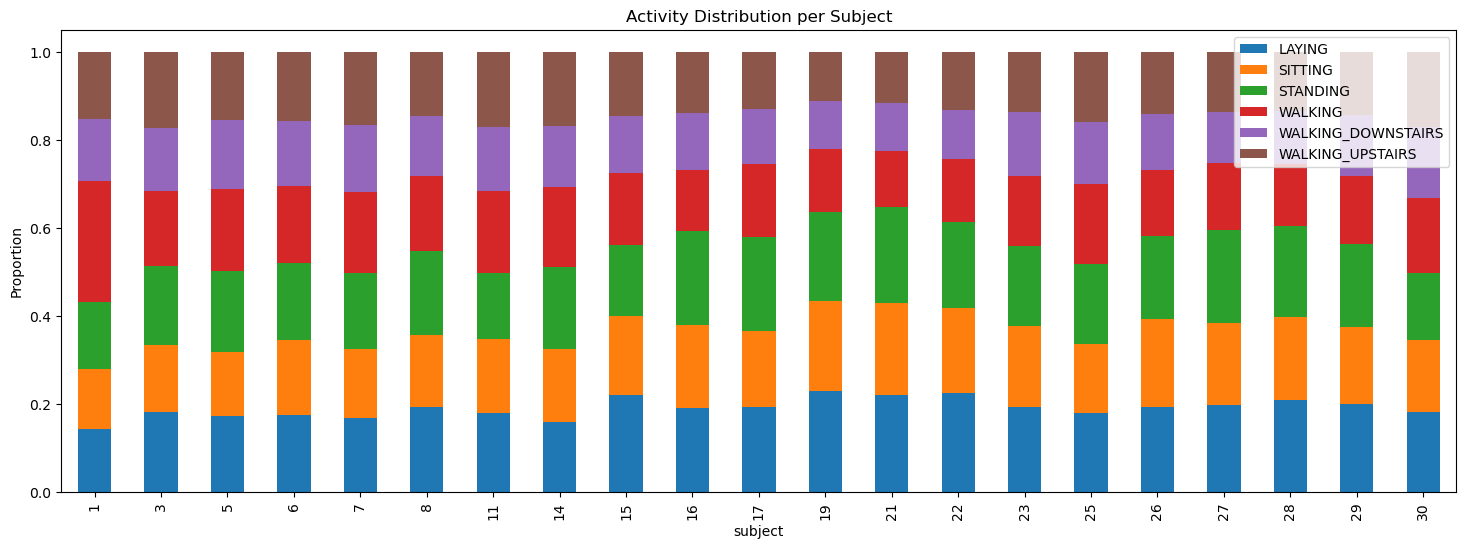

In [4]:
# Frequency barplot
sns.countplot(x='Activity', data=train)
plt.title('Overall Activity Frequency')
plt.show()

# Stacked bar by subject
subject_activity = train.groupby(['subject', 'Activity']).size().unstack(fill_value=0)
subject_activity_pct = subject_activity.div(subject_activity.sum(axis=1), axis=0)
subject_activity_pct.plot(kind='bar', stacked=True, figsize=(18,6))
plt.title('Activity Distribution per Subject')
plt.ylabel('Proportion')
plt.legend(loc='upper right')
plt.show()


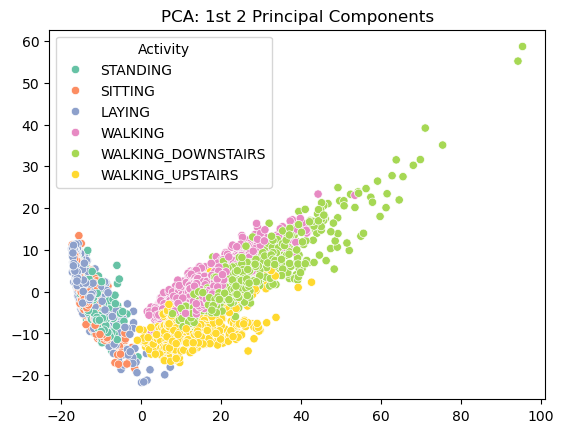

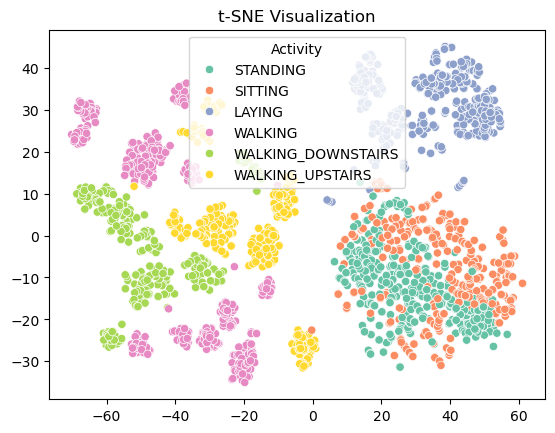

In [5]:
# Standardize numeric features
X = train.drop(columns=['Activity', 'subject'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=train['Activity'], palette="Set2")
plt.title('PCA: 1st 2 Principal Components')
plt.show()

# t-SNE (on 2000 samples)
tsne = TSNE(n_components=2, random_state=42)
tsne_sample = X_scaled[:2000]
tsne_results = tsne.fit_transform(tsne_sample)
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=train['Activity'][:2000], palette="Set2")
plt.title('t-SNE Visualization')
plt.show()


Interpretation:
Most activities form overlapping clusters, reflecting similarities (sitting vs standing) and aiding clinicians in understanding which activities sensors can best distinguish.

In [9]:
# Handle missing values
null_counts = train.isnull().sum()
if null_counts.any():
    train.dropna(inplace=True)  # Or consider imputation with mean/median if justified
    print("Missing values handled by dropping.")

# Feature scaling
X = train.drop(columns=['Activity', 'subject'])
X_test = test.drop(columns=['subject'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Encode target
le = LabelEncoder()
y = le.fit_transform(train['Activity'])

# Outlier detection (IsolationForest)
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(X_scaled)
train = train.loc[outliers==1]  # Keep only inliers

print("Outliers handled with IsolationForest and removed.")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Activity
